In [1]:
from pyralysis.transformers import UVTaper
from pyralysis.io import DaskMS
from pyralysis.reconstruction import Image
import dask
import dask.array as da
import astropy.units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.constants import c
import xarray as xr
from pyralysis.units import lambdas_equivalencies
from pyralysis.transformers.weighting_schemes import Uniform, Robust
from pyralysis.transformers import Gridder, HermitianSymmetry, DirtyMapper, UVTaper
from pyralysis.units import array_unit_conversion
from pyralysis.io import FITS, HDF5
from pyralysis.convolution import PSWF1, Gaussian
from astropy.units import Quantity
from daskms import xds_from_table
import traceback
import warnings
import sys

In [2]:
def get_complete_uvplane(half_gridded_vis, half_gridded_weights=None, apply_fftshift=False):
    h, w = half_gridded_vis.shape[-2:]
    m, n = (h, h)
    ft_full = np.zeros((m, n), dtype=half_gridded_vis.dtype)

    if apply_fftshift:
        ft_full[:h, :w] = np.fft.ifftshift(half_gridded_vis, axes=-2)
    else:
        ft_full[:h, :w] = half_gridded_vis

    if half_gridded_weights is not None:
        weights_full = np.zeros((m, n), dtype=half_gridded_weights.dtype)

        if apply_fftshift:
            weights_full[:h, :w] = np.fft.ifftshift(half_gridded_weights, axes=-2)
        else:
            weights_full[:h, :w] = half_gridded_weights

    X, Y = np.meshgrid(range(m), range(n // 2 + 1, n), indexing='ij')
    ft_full[X, Y] = ft_full[-X, -Y].conj()

    if half_gridded_weights is not None:
        weights_full[X, Y] = weights_full[-X, -Y].conj()

    if apply_fftshift:
        ft_full = np.fft.fftshift(ft_full)
        if half_gridded_weights is not None:
            weights_full = np.fft.fftshift(weights_full)

    if half_gridded_weights is not None:
        return ft_full, weights_full
    else:
        return ft_full

In [3]:
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file, 'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

In [4]:
warnings.showwarning = warn_with_traceback

In [5]:
#x = DaskMS(input_name="/home/miguel/Documents/pyralysis/datasets/antennae/all_fields.ms")
#x = DaskMS(input_name="/home/miguel/Documents/datasets/belen/9.8-9.5.ms", chunks={"row": 100000})
#x = DaskMS(
#    input_name="/home/miguel/Documents/datasets/ALMA/HD135344B/calibrated_cont_self.ms",
#    chunks={
#        "row": 100000,
#        "chan": 1
#    }
#)
#x = DaskMS(input_name="/home/miguel/Documents/datasets/ALMA/HD163296/HD163296_continuum.ms")
x = DaskMS(input_name="/home/miguel/Downloads/RT124_sim739.ms")
#x = DaskMS(
#    input_name="/home/miguel/Documents/datasets/ALMA/AS209/AS209_continuum.ms",
#    chunks={"row": 100000}
#)
#x = DaskMS(input_name="/home/miguel/Documents/datasets/ALMA/PDS70/residuals.ms")

In [6]:
dataset = x.read(filter_flag_column=False, calculate_psf=False)

In [7]:
l = dataset.field.phase_direction_cosines[0]
m = dataset.field.phase_direction_cosines[1]

Text(0.5, 1.0, 'Pointings in deg')

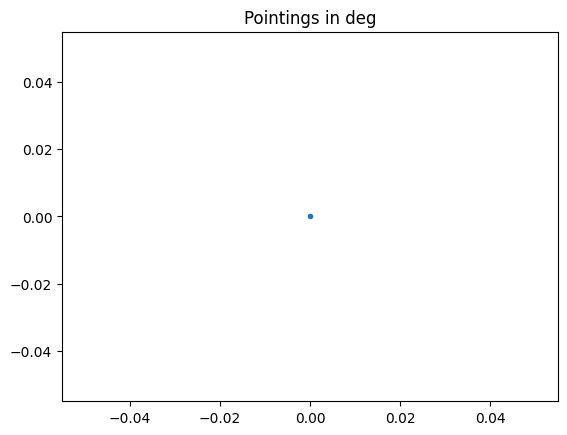

In [8]:
plt.plot(l.to(u.deg), m.to(u.deg), '.')
plt.title("Pointings in {0}".format(u.deg))

In [9]:
hermitian_symmetry = True
padding_factor = 1.

In [10]:
if hermitian_symmetry:
    h_symmetry = HermitianSymmetry(input_data=dataset)
    h_symmetry.apply()

In [11]:
imsize = 1024

In [12]:
dx = dataset.theo_resolution / 7
#dx = 0.005 * u.arcsec

In [13]:
dx

<Quantity 2.17841632e-08 rad>

Text(0.5, 1.0, 'Pointings in pixels')

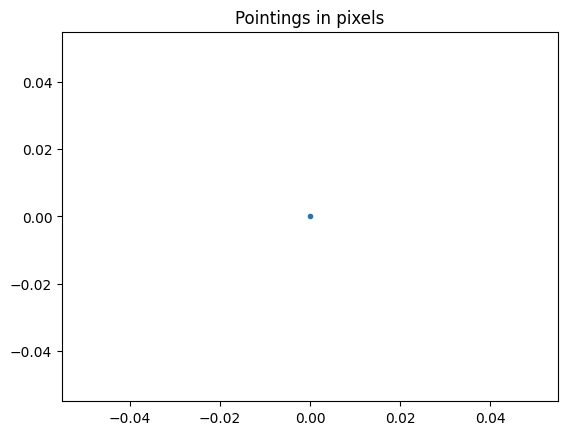

In [14]:
plt.plot(l / dx, m / dx, '.')
plt.title("Pointings in pixels")

Text(0.5, 1.0, 'Pointings in pixels shifted to 512')

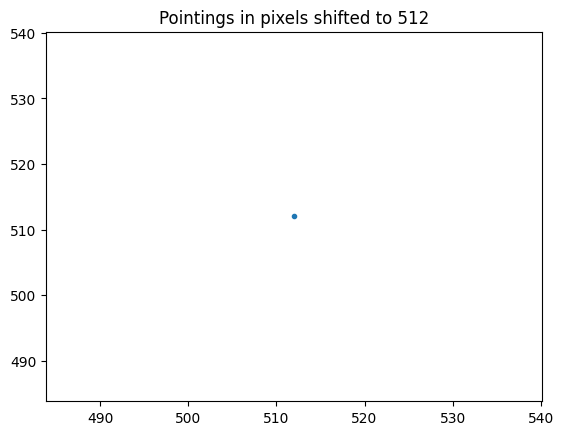

In [15]:
plt.plot(l / dx + imsize // 2, m / dx + imsize // 2, '.')
plt.title("Pointings in pixels shifted to {0}".format(imsize // 2))

In [16]:
pb = dataset.antenna.primary_beam

In [17]:
pb.cellsize = dx
chans = dataset.spws.dataset[0].CHAN_FREQ.data.squeeze(axis=0)

In [18]:
centers_l = (l / (-dx) + imsize // 2).astype(np.int32)
centers_m = (m / dx + imsize // 2).astype(np.int32)

In [19]:
p_beams = da.array(
    [
        pb.beam(
            chans, (imsize, imsize), antenna=np.array([0]), imcenter=(centers_l[i], centers_m[i])
        ) for i in range(centers_l.size)
    ]
)

In [20]:
p_beams_together = da.sum(p_beams, axis=(0, 1, 2))

In [21]:
plt.imshow(p_beams_together)

In [22]:
gridder = Gridder(
    imsize=imsize,
    cellsize=dx,
    hermitian_symmetry=hermitian_symmetry,
    padding_factor=padding_factor
)

In [23]:
fits_io = FITS()

In [24]:
robust_param = 2.0

In [25]:
#uniform = Uniform(input_data=dataset, gridder=gridder)
robust = Robust(input_data=dataset, robust_parameter=robust_param, gridder=gridder)

In [26]:
#uniform.apply()
robust.apply()

In [27]:
# dataset.calculate_psf()

In [28]:
ckernel = None

In [29]:
dirty_mapper = DirtyMapper(
    input_data=dataset,
    imsize=imsize,
    cellsize=dx,
    stokes=["I"],
    hermitian_symmetry=hermitian_symmetry,
    padding_factor=padding_factor,
    ckernel_object=ckernel
)

In [30]:
dirty_mapper.cellsize

<Quantity [-2.17841632e-08,  2.17841632e-08] rad>

In [31]:
dirty_images_robust = dirty_mapper.transform()

In [32]:
dirty_image, dirty_beam = dask.compute(
    *[dirty_images_robust[0].data[0], dirty_images_robust[1].data[0]]
)

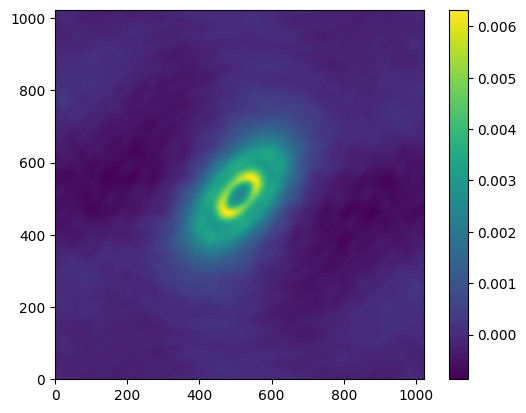

In [33]:
plt.imshow(dirty_image, origin="lower", vmin=np.min(dirty_image), vmax=np.max(dirty_image))
#plt.xlim([800,1200])
#plt.ylim([800, 1200])
plt.colorbar()

In [34]:
np.std(dirty_image), np.min(dirty_image), np.max(dirty_image)

(<xarray.DataArray 'mul-a29dd72617f860b3ee739c2ed893298b' ()>
 array(0.00089134, dtype=float32),
 <xarray.DataArray 'mul-a29dd72617f860b3ee739c2ed893298b' ()>
 array(-0.00087034, dtype=float32),
 <xarray.DataArray 'mul-a29dd72617f860b3ee739c2ed893298b' ()>
 array(0.00632486, dtype=float32))

In [35]:
plt.imshow(dirty_beam, origin="lower", vmin=np.min(dirty_beam), vmax=np.max(dirty_beam))
#plt.xlim([800,1200])
#plt.ylim([800, 1200])
plt.colorbar()

In [36]:
#fits_io.write(dirty_image, output_name="dirty_images_robust_uniform.fits")
#fits_io.write(dirty_beam, output_name="dirty_beam_robust_uniform.fits")

In [37]:
#fits_io.write(dirty_image, output_name="dirty_images_robust_"+str(robust_param)+".fits")
#fits_io.write(dirty_beam, output_name="dirty_beam_robust_"+str(robust_param)+".fits")

In [38]:
gridded_visibilities, gridded_weights = da.compute(
    *[dirty_mapper.uvgridded_visibilities, dirty_mapper.uvgridded_weights]
)

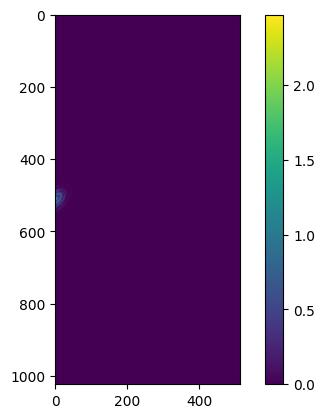

In [39]:
plt.imshow(np.log10(np.abs(gridded_weights[0] * gridded_visibilities[0]) + 1))
plt.colorbar()

In [40]:
np.unravel_index(np.argmax(np.abs(gridded_visibilities[0])), gridded_visibilities[0].shape)

(512, 0)

In [41]:
ft_full, weights_full = get_complete_uvplane(
    gridded_visibilities, gridded_weights, apply_fftshift=True
)

In [42]:
np.unravel_index(np.argmax(np.abs(ft_full)), ft_full.shape)

(512, 512)

(600.0, 400.0)

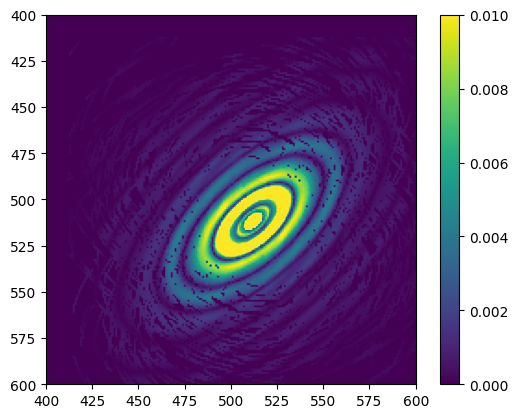

In [43]:
plt.imshow(np.abs(ft_full), vmax=0.01)
plt.colorbar()
plt.xlim([400, 600])
plt.ylim([600, 400])

In [44]:
normalized_weights = weights_full / np.sum(weights_full)
ft_dirty = normalized_weights * ft_full

In [45]:
dirty_image_back = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(ft_dirty))
                                   ).real * ft_dirty.shape[-1] * ft_dirty.shape[-2]

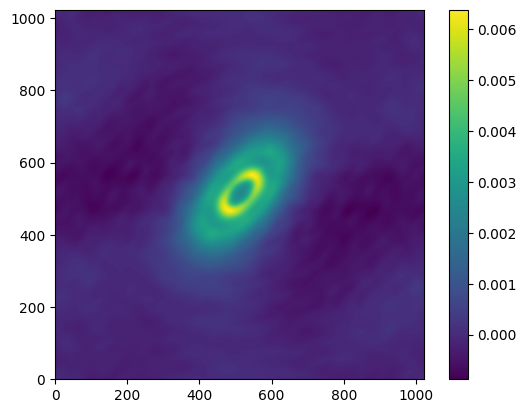

In [46]:
plt.imshow(
    dirty_image_back, origin="lower", vmin=np.min(dirty_image_back), vmax=np.max(dirty_image_back)
)
plt.colorbar()